## How to Reproduce?

In [1]:
# Required Imports
from pathlib import Path
from glob import glob
import SimpleITK
import numpy as np
import time
import torch
import torch as tc
import torchio as tio
import runet

First, define paths to the models and data:

In [2]:
input_path = None # Path to a single file, e.g. Path('/home/input.mha')
output_path = None # Path to the output prediction e.g Path('/home/output.mha')
models_path = None # Path where the downloaded models are saved
# Note - just run this using for loop to calculate for all files in a given directory

Now run the inference:

In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def validation_transforms():
    normalization = tio.RescaleIntensity(out_min_max=(0, 1))
    transforms = tio.Compose([normalization])
    return transforms

def load_image_file_as_array(*, location):
    # input_files = glob(str(location / "*.tiff")) + glob(str(location / "*.mha"))
    # result = SimpleITK.ReadImage(input_files[0])
    result = SimpleITK.ReadImage(location)
    spacing = result.GetSpacing()
    direction = result.GetDirection()
    origin = result.GetOrigin()
    return SimpleITK.GetArrayFromImage(result), spacing, direction, origin

def write_array_as_image_file(*, location, array, spacing, origin, direction):
    # location.mkdir(parents=True, exist_ok=True)
    suffix = ".mha"
    image = SimpleITK.GetImageFromArray(array)
    image.SetSpacing(spacing)
    image.SetOrigin(origin)
    image.SetDirection(direction)
    SimpleITK.WriteImage(
        image,
        # location / f"output{suffix}",
        location,
        useCompression=True,
    )

def _show_torch_cuda_info():

    print("=+=" * 10)
    print("Collecting Torch CUDA information")
    print(f"Torch CUDA is available: {(available := torch.cuda.is_available())}")
    if available:
        print(f"\tnumber of devices: {torch.cuda.device_count()}")
        print(f"\tcurrent device: { (current_device := torch.cuda.current_device())}")
        print(f"\tproperties: {torch.cuda.get_device_properties(current_device)}")
    print("=+=" * 10)

def run():
    # Read the input
    image, spacing, direction, origin = load_image_file_as_array(
        # location=INPUT_PATH / "images/ct-angiography",
        location = input_path,
    )
    # Process the inputs: any way you'd like
    _show_torch_cuda_info()

    ############# Lines You can change ###########
    ### Prepare Models ###
    b_t = time.time()
    device = get_default_device()
    fs_patch_size = (256, 256, 256)
    fs_patch_overlap = (32, 32, 32)
    ss_patch_size = (192, 192, 192)
    ss_patch_overlap = (32, 32, 32)
    
    fs_models = []
    for fold in range(4, 6):
        fs_checkpoint_path = models_path / f"FS_Exp3a_Fold_{fold}_Iteration_400" 
        fs_config = runet.default_config()
        fs_config['use_sigmoid'] = False
        fs_model = runet.RUNet(**fs_config).to(device)
        fs_checkpoint = tc.load(fs_checkpoint_path)
        fs_model.load_state_dict(fs_checkpoint['model_state_dict'])
        fs_model.eval()
        fs_models.append(fs_model)
         
    ss_models = []
    for fold in range(4, 6):              
        ss_checkpoint_path = models_path / f"SS_Exp8Retrain_Fold_{fold}_Iteration_200"  
        ss_config = runet.default_ss_config()
        ss_config['use_sigmoid'] = False
        ss_model = runet.RUNet(**ss_config).to(device)
        ss_checkpoint = tc.load(ss_checkpoint_path)
        ss_model.load_state_dict(ss_checkpoint['model_state_dict'])
        ss_model.eval()
        ss_models.append(ss_model)
    e_t = time.time()
    print(f"Time for model load: {e_t - b_t}")

    ### Run Inference ###

    ### Prepare Subject ###
    b_total = time.time()
    volume = np.flip(np.flip(image, axis=2), axis=1)
    volume = tc.from_numpy(volume.astype(np.float32)).permute(2, 1, 0).unsqueeze(0)
    fs_subject = tio.Subject(
        volume = tio.ScalarImage(tensor=volume),
    )
    transforms = validation_transforms()
    fs_subject = transforms(fs_subject)

    ### Run Inference FS ###
    grid_sampler = tio.inference.GridSampler(
        fs_subject,
        fs_patch_size,
        fs_patch_overlap,
    )
    print(f"First Step. Num patches: {len(grid_sampler)}")
    b_t = time.time()
    with tc.no_grad():
        patch_loader = tc.utils.data.DataLoader(grid_sampler, batch_size=1)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode="hann")
        for patches_batch in patch_loader:
            input_tensor = patches_batch['volume'][tio.DATA].to(tc.float32).to(device)
            locations = patches_batch[tio.LOCATION]
            for idx in range(len(fs_models)):
                if idx == 0:
                    output_fs = fs_models[idx](input_tensor)
                else:
                    output_fs += fs_models[idx](input_tensor)
            output_fs = output_fs / len(fs_models)
            aggregator.add_batch(output_fs, locations)
    output_fs = tc.sigmoid(aggregator.get_output_tensor())[0].to(tc.float32).unsqueeze(0)
    print(f"Output FS Shape: {output_fs.shape}")
    e_t = time.time()
    print(f"Time for first step: {e_t - b_t} seconds.")
    
    ### Run Inference SS ###
    ss_subject = tio.Subject(
        volume = tio.ScalarImage(tensor=volume),
        output_fs = tio.LabelMap(tensor=output_fs)
    )
    transforms = validation_transforms()
    ss_subject = transforms(ss_subject)
    
    grid_sampler = tio.inference.GridSampler(
        ss_subject,
        ss_patch_size,
        ss_patch_overlap,
    )
    print(f"Second Step. Num patches: {len(grid_sampler)}")
    b_t = time.time()
    with tc.no_grad():
        patch_loader = tc.utils.data.DataLoader(grid_sampler, batch_size=1)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode="crop")
        for patches_batch in patch_loader:
            input_tensor = patches_batch['volume'][tio.DATA].to(tc.float32).to(device)
            input_fs = patches_batch['output_fs'][tio.DATA].to(tc.float32).to(device)
            input_tensor = tc.cat((input_tensor, input_fs), dim=1)
            locations = patches_batch[tio.LOCATION]
            for idx in range(len(ss_models)):
                if idx == 0:
                    output_ss = ss_models[idx](input_tensor)
                else:
                    output_ss += ss_models[idx](input_tensor)
            output_ss = output_ss / len(ss_models)
            output_ss = tc.sigmoid(output_ss)
            output_ss = tc.argmax(output_ss, dim=1, keepdim=True)
            aggregator.add_batch(output_ss, locations)
    output_ss = aggregator.get_output_tensor()[0]
    e_t = time.time()
    print(f"Time for second step: {e_t - b_t} seconds.")
    print(f"Output SS Shape: {output_ss.shape}")
    ### Prepare & Return Output ###
    print(f"Output FS Shape: {output_fs.shape}")
    output_ss = output_ss.permute(2, 1, 0)
    print(f"Output SS Shape: {output_ss.shape}")
    output_ss = output_ss.cpu().detach().numpy().astype(np.uint8)
    output_ss = np.flip(np.flip(output_ss, axis=1), axis=2)
    e_total = time.time()
    print(f"Time for whole inference: {e_total - b_total} seconds.")

    ########## Don't Change Anything below this 
    # For some reason if you want to change the lines, make sure the output segmentation has the same properties (spacing, dimension, origin, etc) as the 
    # input volume
    # Save your output
    write_array_as_image_file(
        # location=OUTPUT_PATH / "images/aortic-branches",
        location = output_path,
        array=output_ss,
        spacing=spacing, 
        origin=origin,
        direction=direction, 
    )
    return 0

run()

=+==+==+==+==+==+==+==+==+==+=
Torch CUDA is available: True
	number of devices: 2
	current device: 0
	properties: _CudaDeviceProperties(name='NVIDIA RTX A6000', major=8, minor=6, total_memory=48676MB, multi_processor_count=84)
=+==+==+==+==+==+==+==+==+==+=
Time for model load: 6.952246189117432
First Step. Num patches: 16
Output FS Shape: torch.Size([1, 435, 435, 724])
Time for first step: 13.003297328948975 seconds.
Second Step. Num patches: 45


/tmp/ipykernel_83817/471850141.py:157: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  output_ss = aggregator.get_output_tensor()[0]


Time for second step: 19.245763540267944 seconds.
Output SS Shape: torch.Size([435, 435, 724])
Output FS Shape: torch.Size([1, 435, 435, 724])
Output SS Shape: torch.Size([724, 435, 435])
Time for whole inference: 40.887019872665405 seconds.


0

## Show Results 

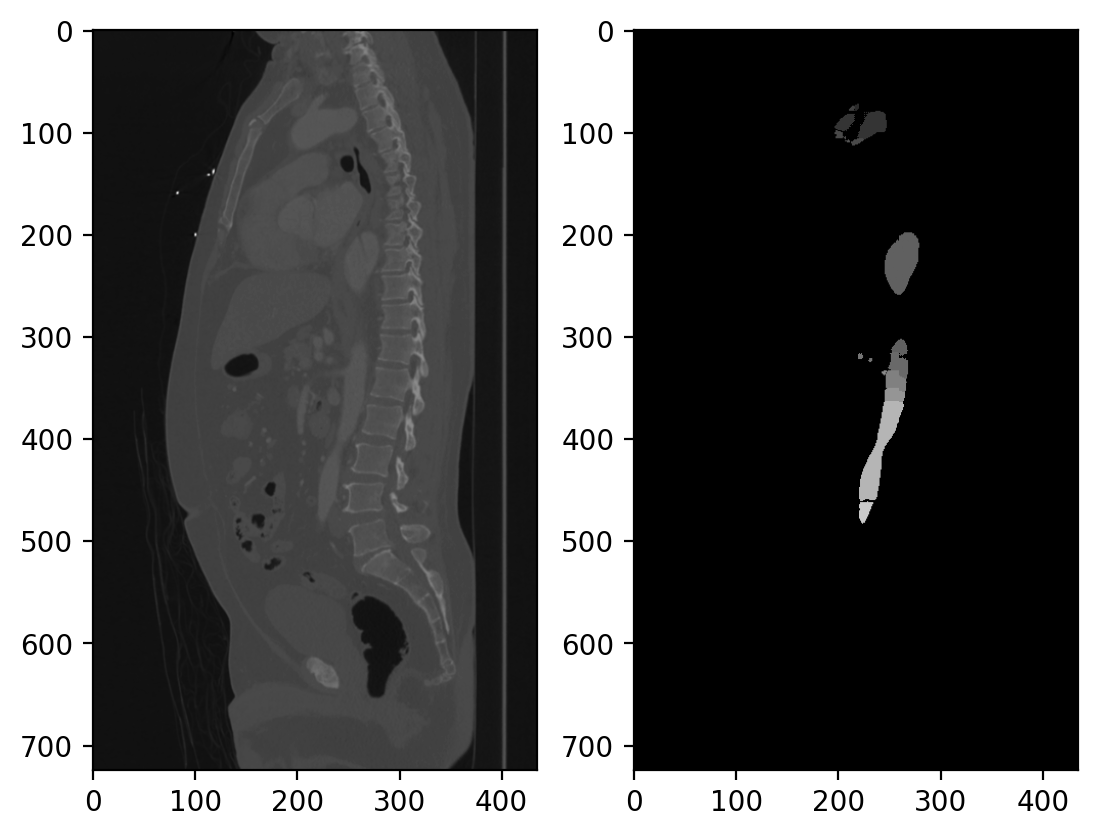

In [20]:
import matplotlib.pyplot as plt

image = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(input_path))
result = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(output_path))

z_slice = 225
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image[::-1, :, z_slice], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result[::-1, :, z_slice], cmap='gray', vmin=0, vmax=24)
plt.show()